In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import sys
import os
import glob
import importlib
import multiprocessing as mp
import itertools
import math
import random 
import numpy as np

from matplotlib import pyplot as plt
from PIL import Image
import scipy.sparse as sparse
import scipy.io as sio
import scipy.stats as stats
import scipy.spatial.distance as dist
from tqdm import tqdm
import pandas as pd
import tables
#import deepdish as dd

sys.path.append('/Users/johnmarshall/Documents/MATLAB/CNMF_E_jjm/python_wrapper/')
sys.path.append('/Users/johnmarshall/caiman_data/post_cnmfe_analysis')
import miniscope_analysis as ma 
import python_utils_jjm as utils_jjm
import jjm_post_cnmfe_fns as jjm
import align_msCam_tobehavior as align_tracking

from importlib import reload
%matplotlib inline

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def plot_traces(neuron_idxs, frame_range, data_to_plot, normalize=True, fsize=(15,10)):
    """Inputs:
    neuron_idxs : list of neuron indicies to plot, e.g. range(1, 2) or [3, 50, 90]
    frame_range : tuple (start_frame, end_frame)
    data_to_plot : list of data to plot (e.g. ['C', 'C_raw'])        
    """
    plt.figure(figsize=fsize)
    plt.axis('on')
    arrays_to_plot = [np.array(results.cnmfe_results[data]) for data in data_to_plot]
    for idx in neurons_idx:
        for array in arrays_to_plot:
            if normalize==True:
                plt.plot(utils_jjm.normalize(array[idx, frame_range[0]:frame_range[1]]) + idx)
            else:
                plt.plot(array[idx, frames[0]:frames[1]] + idx)
    return()

In [4]:
results_file = r'C:\Users\Santiago PC\Documents\miniscope_data\demos\memmap_0000memmap_0000_resized_motion_corrected_source_extraction\frames_1_1000\LOGS_30-Jan_14_46_09\out.mat'
results = ma.miniscope_session(results_file)

## Correlation Coefficient for every neuron pair through FULL video

In [ ]:
#calculating correlation coeffience for every neuron pair
C1 = results.cnmfe_results['C'][:]
indicies = range(0,len(C1))
CC = []
for neuron_1 in indicies:
    for neuron_2 in indicies:
        if neuron_1 != neuron_2:
            corrcoef = stats.pearsonr(C1[neuron_1],C1[neuron_2])
            CC.append(corrcoef)
len(CC)

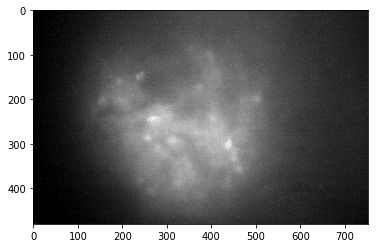

In [5]:
img_file = '/Users/Santiago PC/Documents/MiniscopeMovies/GRIN032/memmap_0000memmap_0023_resized_source_extraction_20-01-09.187/H17_M30_S22msCam2_f29.tif'
img_from_file = plt.imread(img_file)
plt.imshow(img_from_file, cmap='gray')

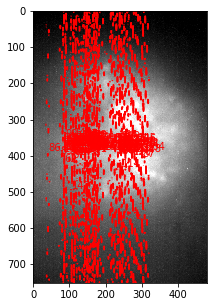

In [6]:
%matplotlib inline
neurons_idx = range(150)
plt.rcParams['figure.figsize'] = [5, 5]
coordinates = utils_jjm.plot_contours(results.cnmfe_results['A'].todense(), np.transpose(img_from_file), list_to_plot=neurons_idx, display_numbers=True, maxthr=.4,cmap='gray', colors='r')

## Calculating Relative Distance of every neuron pair

In [7]:
#storing CoM values in a seperate list
coordinates
CoM = []
for neuron in coordinates:
    CoM.append(neuron['CoM'])
len(CoM)

150

In [8]:
#calculating relative distance for each neuron pair's CoM
rel_dist = []
for neuron1 in CoM:
    for neuron2 in CoM:
        if neuron1[0] != neuron2[0]:
            rel_dist.append(math.sqrt(((neuron1[0] - neuron2[0])**2) + ((neuron1[1] - neuron2[1])**2)))
len(rel_dist)

22350

In [9]:
rel_dist_df = pd.DataFrame(rel_dist)

In [ ]:
CC_df = pd.DataFrame(CC)

In [ ]:
%matplotlib qt
plt.scatter(rel_dist_df, CC_df[0])
plt.ylabel('CC')
plt.xlabel('CoM distance in pixels')
plt.show()

## Specific Threshold Calculation for full video

In [ ]:
#making a new list where values are tested by a threshold, if passing 1, if not 0
activity = results.cnmfe_results['C']
threshold_list = []
vid_length = len(results.cnmfe_results['C'][:].transpose())
for neuron in activity:
    for moment in neuron:
        if moment >= 0.75:
            threshold_list.append(1)
        else:
            threshold_list.append(0)
            
len(threshold_list)

In [ ]:
#function chunking previous list into sets of the video length(in frames), affectively seperating each neuron from eachother
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [ ]:
vid_length = len(results.cnmfe_results['C'][:].transpose())
neuron_threshold_list = (list(chunks(threshold_list, vid_length)))

In [ ]:
#verify the blocking is accurate
plt.plot(neuron_threshold_list[0])
plt.plot(results.cnmfe_results['C'][0])

In [ ]:
#correlation coefficience for threshold events in every neuron pair
C1_nt = neuron_threshold_list
indicies = range(0,len(C1_nt))
CC_nt = []
for neuron_1 in indicies:
    for neuron_2 in indicies:
        if neuron_1 != neuron_2:
            corrcoef = stats.pearsonr(C1_nt[neuron_1],C1_nt[neuron_2])
            CC_nt.append(corrcoef)
len(CC_nt)

In [ ]:
CC_nt_df = pd.DataFrame(CC_nt)

In [ ]:
%matplotlib qt
plt.scatter(rel_dist, CC_nt_df[0])
plt.xlabel('Relative Distance in Pixels')
plt.ylabel('Correlation Coefficient')
plt.draw()

## Threshold Calculation including certain event in time by frames

In [ ]:
#new code to space out at certain events in time
activity = results.cnmfe_results['C']
threshold_list_t = []
t = 200
for neuron in activity:
    for moment in neuron[range(0,t)]:
        if moment >= 0.75:
            threshold_list_t.append(1)
        else:
            threshold_list_t.append(0)
            
len(threshold_list_t)

In [ ]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [ ]:
neuron_threshold_list_t = (list(chunks(threshold_list_t, len(range(0,t)))))

In [ ]:
#validate pairing
plt.plot(neuron_threshold_list_t[0])
plt.plot(results.cnmfe_results['C'][0])

In [ ]:
#CC for certain event in t
C1_nt_t = neuron_threshold_list_t
indicies = range(0,len(C1_nt_t))
CC_nt_t = []
for neuron_1 in indicies:
    for neuron_2 in indicies:
        if neuron_1 != neuron_2:
            corrcoef = stats.pearsonr(C1_nt_t[neuron_1],C1_nt_t[neuron_2])
            CC_nt_t.append(corrcoef)
len(CC_nt_t)

In [ ]:
CC_nt_t_df = pd.DataFrame(CC_nt_t)

In [ ]:
#plotting correlation coeffecient against relative distance at certain time
%matplotlib qt
plt.scatter(rel_dist_df, CC_nt_t_df[0])
plt.title('10 Seconds')
plt.ylabel('CC')
plt.xlabel('CoM distance in pixels')
plt.show()

In [ ]:
#check something (both full and 10 seconds correlation)
%matplotlib qt
plt.scatter(rel_dist_df, CC_nt_df[0], label= 'Full video')
plt.scatter(rel_dist_df, CC_nt_t_df[0], label='first 10 seconds')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Relative Distance in Pixels')
plt.legend()


## Making a trendline (in progress (poor fitting))

In [ ]:
%matplotlib qt
plt.scatter(rel_dist_df, CC_nt_df[0], label= 'Full video')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Relative Distance in Pixels')
z = np.polyfit(rel_dist_df[0], CC_nt_df[0], 1)
p = np.poly1d(z)
plt.plot(rel_dist_df[0],p(rel_dist_df[0]),"r--")
plt.legend()

## Chunk Analysis

In [10]:
#create a new list that sets an arbitrary threshold and assigns each value 0 or 1
activity = results.cnmfe_results['C']
threshold_list = []
vid_length = len(results.cnmfe_results['C'][:].transpose())
for neuron in activity:
    for moment in neuron:
        if moment >= 0.75:
            threshold_list.append(1)
        else:
            threshold_list.append(0)
            
len(threshold_list)

150000

In [11]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [12]:
#divides the threshold_list into n-sized slices (frame_division) 20 at 20fps = 1 second
frame_division = 20
chunked_threshold_list = (list(chunks(threshold_list, frame_division)))

In [13]:
len(chunked_threshold_list)

7500

In [14]:
zero_one = np.asarray(chunked_threshold_list)

In [ ]:
zero_one

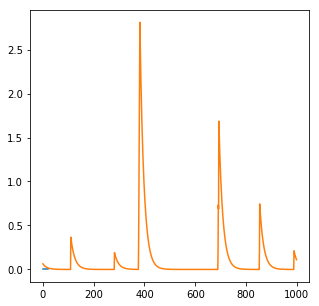

In [15]:
#shows chunk
plt.plot(zero_one[0])
plt.plot(results.cnmfe_results['C'][0])

In [16]:
#for each chunk (zero_one is an array from chunked_threshold_list) assign 'Yes' and 'No' from argument using np.any
zero_one
yes_no = []
for chunk in zero_one:
    if np.any(chunk > 0.50):
        yes_no.append('Yes')
    else:
        np.any(chunk <= 0.50)
        yes_no.append('No')

In [17]:
#using the yes_no list, extend by frame_division 1's if passing a threshold --'Yes', 0's if not
block_list = []
zeros = np.zeros(100)
ones = np.ones(100)
for item in yes_no:
    if 'Yes' in item:
        block_list.extend([1] * frame_division)
    else:
        block_list.extend([0] * frame_division)

In [18]:
#block_list should equal the same amount of values for the original threshold_list
len(block_list)

150000

In [19]:
#chunk the block_list into neuron list (divide by the video_length, length should be number of neurons
vid_length = len(results.cnmfe_results['C'][:].transpose())
block_neuron_list = (list(chunks(block_list, vid_length)))
len(block_neuron_list)

150

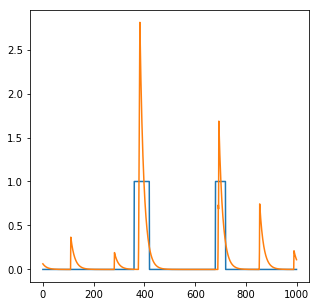

In [20]:
#varify
plt.plot(block_neuron_list[0])
plt.plot(results.cnmfe_results['C'][0])

In [21]:
#len(block_nt_CC) verifies that same pairs are excluded
block_nt = block_neuron_list
indicies = range(0,len(block_nt))
block_nt_CC = []
for neuron_1 in indicies:
    for neuron_2 in indicies:
        if neuron_1 != neuron_2:
            corrcoef = stats.pearsonr(block_nt[neuron_1],block_nt[neuron_2])
            block_nt_CC.append(corrcoef)

len(block_nt_CC)

C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:5256: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


22350

In [22]:
block_df = pd.DataFrame(block_nt_CC)

In [24]:
print(len(block_df))
print(len(rel_dist_df))

22350
22350


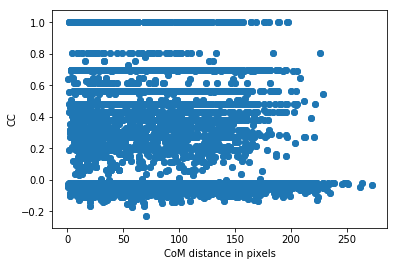

In [25]:
%matplotlib qt
plt.scatter(rel_dist_df, block_df[0])
plt.ylabel('CC')
plt.xlabel('CoM distance in pixels')
plt.show()

## plotting fun

In [ ]:
plt.plot(block_neuron_list[0])
plt.plot(results.cnmfe_results['C'][0])

In [ ]:
%matplotlib qt
plt.scatter(rel_dist_df, CC_df[0])
plt.scatter(rel_dist_df, block_df[0])
plt.ylabel('CC')
plt.xlabel('CoM distance in pixels')
plt.show()

In [ ]:
%matplotlib qt
plt.scatter(rel_dist_df, block_df[0], label= 'Full video')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Relative Distance in Pixels')
z = np.polyfit(rel_dist_df[0], block_df[0], 1)
p = np.poly1d(z)
plt.plot(rel_dist_df[0],p(rel_dist_df[0]),"r--")
plt.legend()